## 更小的方差，使得概率密度更加集中，边缘上的点密度降低

In [1]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
# 这种用法很有意思
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue  # 有些component没有被激活
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


In [3]:
# Parameters
n_samples = 100

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4. * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.
    X[i, 0] = x + np.random.normal(0, 0.1)  # 添加随机误差
    X[i, 1] = 3. * (np.sin(x) + np.random.normal(0, .2))


In [4]:
X.shape

(100, 2)

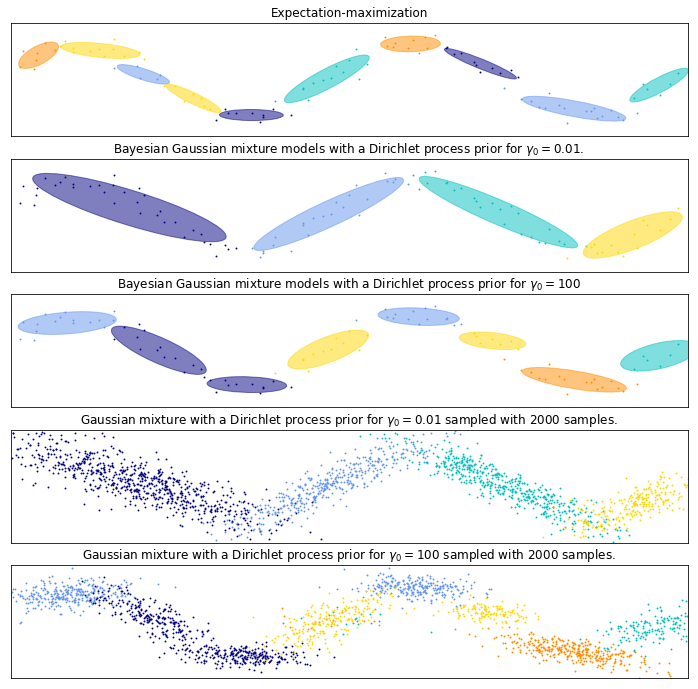

In [5]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=.04, top=0.95, hspace=.2, wspace=.05,
                    left=.03, right=.97)

# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full',
                              max_iter=100).fit(X)
# 第一个图
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Expectation-maximization')

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="random", max_iter=100, random_state=2).fit(X)
# 第二个图
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=0.01$.")

# 从生成模型中抽样
X_s, y_s = dpgmm.sample(n_samples=2000)
# 第四个图
plot_samples(X_s, y_s, dpgmm.n_components, 0,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=0.01$ sampled with $2000$ samples.")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e+2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
# 第三个图
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")

X_s, y_s = dpgmm.sample(n_samples=2000)
# 第五个图
plot_samples(X_s, y_s, dpgmm.n_components, 1,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=100$ sampled with $2000$ samples.")

#### weight_concentration_prior 在一定范围内改变（1000 - 5000）对聚类的结果影响不大
#### covariance_prior 的改变对聚类结果影响更大

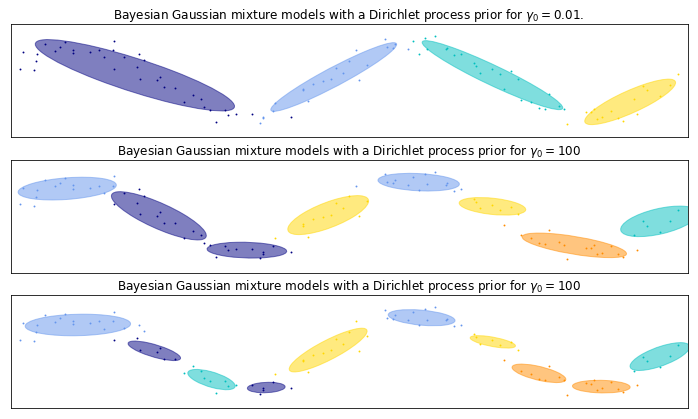

In [6]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=.04, top=0.95, hspace=.2, wspace=.05,
                    left=.03, right=.97)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e-4 * np.eye(2),
    init_params="random", max_iter=100, random_state=2).fit(X)
# 第1个图
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 0,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=0.01$.")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e+2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
# 第2个图
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e+3,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e-1 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
# 第2个图
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")


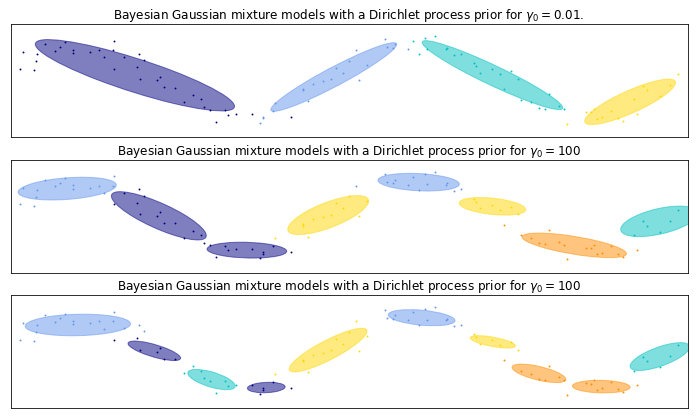

In [7]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=.04, top=0.95, hspace=.2, wspace=.05,
                    left=.03, right=.97)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e-4 * np.eye(2),
    init_params="random", max_iter=100, random_state=2).fit(X)
# 第1个图
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 0,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=0.01$.")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e+2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
# 第2个图
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e8,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e-1 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
# 第2个图
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")


In [8]:
dpgmm

BayesianGaussianMixture(covariance_prior=array([[ 0.1,  0. ],
       [ 0. ,  0.1]]),
            covariance_type='full', degrees_of_freedom_prior=None,
            init_params='kmeans', max_iter=100, mean_precision_prior=0.01,
            mean_prior=None, n_components=10, n_init=1, random_state=2,
            reg_covar=1e-06, tol=0.001, verbose=0, verbose_interval=10,
            warm_start=False, weight_concentration_prior=100000000.0,
            weight_concentration_prior_type='dirichlet_process')

#### 从训练好的dpgmm模型抽样
- 参数：抽样个数
- 返回值：样本以及样本所属component id
- 文档：[link](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture.sample)

In [12]:
sample = dpgmm.sample(10)

In [18]:
sample

(array([[-4.59444388,  1.32691516],
        [-4.16459118,  2.92147413],
        [ 3.29724312,  0.38282234],
        [ 3.76138375, -1.59003536],
        [ 1.24514311,  3.5730646 ],
        [ 1.3696256 ,  2.85194273],
        [ 0.1082325 ,  0.25787825],
        [ 0.41514868,  2.08761627],
        [ 0.06498178,  0.42928835],
        [ 4.40280587, -3.65268101]]), array([2, 2, 3, 4, 7, 7, 8, 8, 8, 9]))

In [15]:
dpgmm.predict(sample[0])

array([2, 2, 3, 4, 7, 7, 8, 8, 8, 9])

In [17]:
dpgmm.predict_proba(sample[0])[np.arange(10), dpgmm.predict(sample[0])]

array([ 0.99757075,  0.99998973,  0.99978095,  0.9999766 ,  0.96687721,
        0.99262136,  1.        ,  0.99891518,  1.        ,  0.93219272])

In [19]:
import pandas as pd

In [20]:
new_samples = pd.DataFrame(index=np.arange(10), columns=['a', 'b', 'id'])

In [21]:
new_samples[['a', 'b']] = sample[0]

In [22]:
new_samples['id'] = sample[1]

In [23]:
new_samples

,a,b,id
0,-4.59444,1.32692,2
1,-4.16459,2.92147,2
2,3.29724,0.382822,3
3,3.76138,-1.59004,4
4,1.24514,3.57306,7
5,1.36963,2.85194,7
6,0.108233,0.257878,8
7,0.415149,2.08762,8
8,0.0649818,0.429288,8
9,4.40281,-3.65268,9


In [24]:
ab = pd.DataFrame()

In [28]:
ab = ab.append(new_samples)

In [30]:
ab.append(new_samples)

,a,b,id
0,-4.59444,1.32692,2
1,-4.16459,2.92147,2
2,3.29724,0.382822,3
3,3.76138,-1.59004,4
4,1.24514,3.57306,7
5,1.36963,2.85194,7
6,0.108233,0.257878,8
7,0.415149,2.08762,8
8,0.0649818,0.429288,8
9,4.40281,-3.65268,9


In [31]:
ab

,a,b,id
0,-4.59444,1.32692,2
1,-4.16459,2.92147,2
2,3.29724,0.382822,3
3,3.76138,-1.59004,4
4,1.24514,3.57306,7
5,1.36963,2.85194,7
6,0.108233,0.257878,8
7,0.415149,2.08762,8
8,0.0649818,0.429288,8
9,4.40281,-3.65268,9


In [33]:
', '.join([str(i) for i in ab.index.tolist()])

'0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9'

In [34]:
abc = 'ksks'

In [35]:
str(abc)

'ksks'

In [36]:
ab.index.map(str)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9'],
      dtype='object')

In [38]:
ab.index = ab.index.map(str)

In [40]:
ab.index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9'],
      dtype='object')

In [42]:
a_list = ['a', 'b', 'c']
b_list = ['c', 'dd', 'ff']

In [43]:
set(a_list) & set(b_list)

{'c'}

In [46]:
int(101/2)

50